In [1]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes -c conda-forge wordcloud 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\custjo01\AppData\Local\Continuum\Anaconda3

  added / updated specs: 
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.1.18  |                0         178 KB  conda-forge
    gensim-3.4.0               |      py36_vc14_0        21.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        21.6 MB

The following packages will be UPDATED:

    ca-certificates: 2017.11.5-0          conda-forge --> 2018.1.18-0       conda-forge
    gensim:          3.4.0-py36h452e1ab_0             --> 3.4.0-py36_vc14_0 conda-forge [vc14]





ca-certificates 2018.1.18:            |   0% 

gensim 3.4.0:            |   0% 

CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/win-64/ca-certificates-2018.1.18-0.tar.bz2>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/win-64/gensim-3.4.0-py36_vc14_0.tar.bz2>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.





In [48]:
%matplotlib inline
import os
import re
import matplotlib.pyplot as plt
import codecs
import wordcloud

In [49]:
home = os.path.expanduser("~")

In [50]:
bibFile = r"scopus.bib";

In [51]:
content ="";
with codecs.open(bibFile,'r',encoding="utf8") as f:
    content = f.read()

In [52]:
def parseBibtex(stringContent):
    entries = [];
    state = 0;
    key   = "";
    value = "";
    entry = {};
    openBrackets = 0;

    for c in stringContent:
        if state == 0:
            #the beging of a new entry is detected so goes to next state
            if c == '@':
                state = 1;
                entry ={};
                continue;
            elif c in (',', ' ', '\n', '\t'):
                continue;

        elif state == 1:
            #Store entry type until a bracket could be found '{' then goes to next state
            if c == "{":
                entry['type'] = value;
                value ="";
                state = 2;
                continue;
        elif state == 2:
            #Read citation key until comma could be found
            if c == ",":
                entry['citationKey'] = value;
                value = "";
                state = 3;
                continue;
        elif state == 3:
            if c in ("", "="):
                #ignore
                continue;
            elif c == "{":
                #Read all caracteres until an open bracked could be found and store it as attribute key
                key = value.strip();
                value = "";
                state = 4;
                continue;
            elif c == "}":
                #Object end
                state =0;
                entries.append(entry);
                entry = {};
                continue;
            elif c in (',','\n'):
                continue;
        elif state == 4:
            #we are inside a attribute value which could have other '{'.
            #if an open bracket was '{' start counting it and if and close bracket appear decrease the counter.
            #the the counter is zero and an '{' was found than close the atribute value and return to previous state,
            #waiting
            if c == "{":
                openBrackets += 1;
            elif c =="}" and openBrackets !=0:
                openBrackets -= 1;
            elif c =="}" and openBrackets ==0:
                entry[key]=value.strip();
                key ="";
                value ="";
                state = 3;
                continue;
        value = value + c;
    return entries;

In [53]:
entries = parseBibtex(content);

# Análise da bibliografia

In [54]:
import pandas as pd;
import numpy as np;
import math;
from collections import defaultdict;
import matplotlib.pyplot as plt;
%matplotlib inline

In [55]:
df = pd.DataFrame(entries);

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 29 columns):
abbrev_source_title    254 non-null object
abstract               251 non-null object
affiliation            251 non-null object
art_number             52 non-null object
author                 254 non-null object
author_keywords        168 non-null object
citationKey            254 non-null object
coden                  28 non-null object
document_type          254 non-null object
doi                    189 non-null object
editor                 106 non-null object
isbn                   97 non-null object
issn                   206 non-null object
journal                254 non-null object
keywords               196 non-null object
language               254 non-null object
note                   254 non-null object
number                 81 non-null object
page_count             2 non-null object
pages                  199 non-null object
publisher              254 non-null objec

In [57]:
df['_citedby']=df.note.apply(lambda x: int(re.sub(r"cited By (\d+).*",r"\1",x)));
df['note']    =df.note.apply(lambda x: re.sub(r"(cited By \d+;?)(.*)",r"\2",x));
df['_journal']=df.journal.apply(lambda x: re.sub(r"\d+(st|th|rd)|20\d\d",r"",x));

In [58]:
df.drop(['abbrev_source_title','art_number','url',
         'page_count','coden','editor',
         'sponsors',
         'language',
         'isbn',
        'source'], axis=1, inplace=True)

In [59]:
df = df[[
    u'title',u'author',u'document_type', u'year', u'abstract', u'publisher', u'journal',
 u'author_keywords', 'citationKey',  u'affiliation', u'doi', u'issn', u'keywords',
 u'note', u'number', u'pages', u'references', 'type', u'volume', '_citedby', '_journal']]

In [60]:
df.head()

,title,author,document_type,year,abstract,publisher,journal,author_keywords,citationKey,affiliation,...,issn,keywords,note,number,pages,references,type,volume,_citedby,_journal
0,On the role of words in the network structure ...,"Akimushkin, C. and Amancio, D.R. and Oliveira,...",Article,2018,Well-established automatic analyses of texts m...,Elsevier B.V.,Physica A: Statistical Mechanics and its Appli...,Authorship attribution; Burstiness; Complex ...,Akimushkin201849,"São Carlos Institute of Physics, University of...",...,03784371,"Complex networks; Linguistics; Semantics, Au...",,NaN,49-58,"Liang, W., Spectra of english evolving word co...",\rARTICLE,495,0,Physica A: Statistical Mechanics and its Appli...
1,An ensemble scheme based on language function ...,"Onan, A.",Article,2018,Text genre classification is the process of id...,SAGE Publications Ltd,Journal of Information Science,ensemble learning; language function analysis...,Onan201828,"Department of Computer Engineering, Celal Baya...",...,01655515,Abstracting; Artificial intelligence; Comput...,,1,28-47,"Han, J., Kamber, M., (2006) Data mining: conce...",\r\r\rARTICLE,44,0,Journal of Information Science
2,Document embeddings learned on various types o...,"Gómez-Adorno, H. and Posadas-Durán, J.-P. and ...",Article in Press,2018,"Recently, document embeddings methods have bee...",Springer-Verlag Wien,Computing,Authorship attribution; Doc2vec; Document em...,Gómez-Adorno20181,"Centro de Investigación en Computación (CIC), ...",...,0010485X,"Computer programming; Neural networks, Author...",Article in Press,NaN,1-16,NaN,\r\r\rARTICLE,NaN,0,Computing
3,Modified principal component analysis for iden...,"Chu, K. and Liu, W. and She, Y. and Hua, Z. an...",Article,2018,Identification of the key environmental indica...,MDPI AG,Water (Switzerland),Coast; Key environmental indicators; Modifie...,Chu2018,Key Laboratory of Integrated Regulation and Re...,...,20734441,Biodiversity; Carbon; Coastal zones; Correl...,,1,NaN,"Yue, Q., Zhao, M., Yu, H.M., Xu, W., Ou, L., T...",\r\r\rARTICLE,10,0,Water (Switzerland)
4,Analysis of multiple classifiers performance f...,"Baron, G.",Conference Paper,2018,In authorship attribution domain single classi...,Springer Science and Business Media Deutschlan...,"Smart Innovation, Systems and Technologies",Authorship attribution; Discretization; Ense...,Baron201833,"Silesian University of Technology, Akademicka ...",...,21903018,Authorship attribution; Discretizations; Ens...,Conference of 9th KES International Conferenc...,NaN,33-42,"Baron, G., Influence of data discretization on...",\r\r\rARTICLE,73,1,"Smart Innovation, Systems and Technologies"


## Pesquisadores que participaram do maior número de publicações

In [61]:
authors = defaultdict(int);
for a in df.author.tolist():
    a = re.split(r"\s*and\s*",a);
    for aa in a:
        aa = aa.split(',');
        if len(aa) > 1:
            aa = aa[1]+" "+aa[0];
        else:
            aa = aa[0]
        authors[aa]+=1;

pd.DataFrame({
    "authors":list(authors.keys()), "count":list(authors.values())}).sort_values(by=['count',"authors"], ascending=False).head(20)

,authors,count
120,E. Stamatatos,11
155,M. Potthast,9
156,B. Stein,9
86,J. Savoy,8
6,G. Sidorov,7
169,M. Tschuggnall,5
171,W. Daelemans,4
17,U. Stańczyk,4
137,R. Kern,4
131,P. Rosso,4


In [62]:
authors = defaultdict(float);
maxYear = float(df.year.max())
for a,citation, year in zip(df.author.tolist(), df._citedby.tolist(), df.year.tolist()):
    a = re.split(r"\s*and\s*",a);
    factor = maxYear / int(year);
    for aa in a:
        aa = aa.split(',');
        if len(aa) > 1:
            aa = aa[1]+" "+aa[0];
        else:
            aa = aa[0]
        if aa in authors:
            authors[aa]+= citation * factor;
        else:
            authors[aa] = citation * factor;

pd.DataFrame({
    "authors":list(authors.keys()),
    "citation":list(authors.values())
}).groupby(by='authors').sum().reset_index().sort_values(by=['citation',"authors"], ascending=False).head(20)

,authors,citation
375,M. Potthast,78.077393
76,B. Stein,78.077393
149,E. Stamatatos,70.067967
383,M. Tschuggnall,37.025788
458,P. Rosso,34.030262
589,W. Daelemans,32.035226
172,F. Rangel,32.029270
565,T. Solorio,30.042182
268,J. Savoy,30.038706
369,M. Montes-Y-Gómez,29.041190


In [63]:
def cleanAuthor(x):
    authors ="";
    x = re.split(r"\s+and\s+",x);
    firstOccour = True;
    for author in x:
        author = author.split(',');
        if len(author) > 1:
            author = author[1]+" "+author[0];
        else:
            author = author[0];
        if firstOccour:
            firstOccour = False;
        else:
            authors += " and "
        authors +=  author;
    return authors;
    
df.author = df.author.apply(lambda x: cleanAuthor(x));

In [64]:
df.head()

,title,author,document_type,year,abstract,publisher,journal,author_keywords,citationKey,affiliation,...,issn,keywords,note,number,pages,references,type,volume,_citedby,_journal
0,On the role of words in the network structure ...,C. Akimushkin and D.R. Amancio and O.N. Oli...,Article,2018,Well-established automatic analyses of texts m...,Elsevier B.V.,Physica A: Statistical Mechanics and its Appli...,Authorship attribution; Burstiness; Complex ...,Akimushkin201849,"São Carlos Institute of Physics, University of...",...,03784371,"Complex networks; Linguistics; Semantics, Au...",,NaN,49-58,"Liang, W., Spectra of english evolving word co...",\rARTICLE,495,0,Physica A: Statistical Mechanics and its Appli...
1,An ensemble scheme based on language function ...,A. Onan,Article,2018,Text genre classification is the process of id...,SAGE Publications Ltd,Journal of Information Science,ensemble learning; language function analysis...,Onan201828,"Department of Computer Engineering, Celal Baya...",...,01655515,Abstracting; Artificial intelligence; Comput...,,1,28-47,"Han, J., Kamber, M., (2006) Data mining: conce...",\r\r\rARTICLE,44,0,Journal of Information Science
2,Document embeddings learned on various types o...,H. Gómez-Adorno and J.-P. Posadas-Durán and ...,Article in Press,2018,"Recently, document embeddings methods have bee...",Springer-Verlag Wien,Computing,Authorship attribution; Doc2vec; Document em...,Gómez-Adorno20181,"Centro de Investigación en Computación (CIC), ...",...,0010485X,"Computer programming; Neural networks, Author...",Article in Press,NaN,1-16,NaN,\r\r\rARTICLE,NaN,0,Computing
3,Modified principal component analysis for iden...,K. Chu and W. Liu and Y. She and Z. Hua an...,Article,2018,Identification of the key environmental indica...,MDPI AG,Water (Switzerland),Coast; Key environmental indicators; Modifie...,Chu2018,Key Laboratory of Integrated Regulation and Re...,...,20734441,Biodiversity; Carbon; Coastal zones; Correl...,,1,NaN,"Yue, Q., Zhao, M., Yu, H.M., Xu, W., Ou, L., T...",\r\r\rARTICLE,10,0,Water (Switzerland)
4,Analysis of multiple classifiers performance f...,G. Baron,Conference Paper,2018,In authorship attribution domain single classi...,Springer Science and Business Media Deutschlan...,"Smart Innovation, Systems and Technologies",Authorship attribution; Discretization; Ense...,Baron201833,"Silesian University of Technology, Akademicka ...",...,21903018,Authorship attribution; Discretizations; Ens...,Conference of 9th KES International Conferenc...,NaN,33-42,"Baron, G., Influence of data discretization on...",\r\r\rARTICLE,73,1,"Smart Innovation, Systems and Technologies"


In [65]:
df.groupby(by=["type", "document_type"])['type','abstract'].count()

type  abstract
type             document_type                   
\r\r\rARTICLE    Article             91        88
                 Article in Press     9         9
                 Book Chapter         3         3
                 Conference Paper    44        44
                 Review               5         5
\r\r\rBOOK       Book Chapter         1         1
\r\r\rCONFERENCE Conference Paper   100       100
\rARTICLE        Article              1         1

In [66]:
df.groupby(by=["type", "document_type"])['type','abstract'].count()

type  abstract
type             document_type                   
\r\r\rARTICLE    Article             91        88
                 Article in Press     9         9
                 Book Chapter         3         3
                 Conference Paper    44        44
                 Review               5         5
\r\r\rBOOK       Book Chapter         1         1
\r\r\rCONFERENCE Conference Paper   100       100
\rARTICLE        Article              1         1

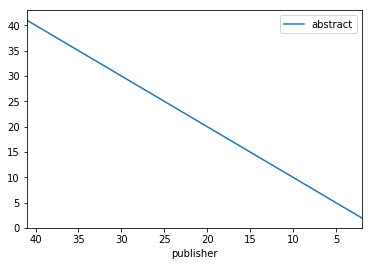

In [67]:
df.groupby(by=["publisher"])['publisher','abstract'].count().sort_values(by=['abstract'], ascending=False).head(20).plot(x='publisher',y='abstract')

In [68]:
def splitList(thelist):
    keys = defaultdict(int);
    for k in thelist:
        if  not isinstance(k,float):
            for kk in set(k.replace(',',';').split(";")):
                kk = kk.upper();
                kk = re.sub(r"\b(\w+)(E?S)\b",r" \1",kk);
                kk = re.sub(r"\s{2,}"," ",kk).strip()
                keys[kk]+=1;
    return keys;

In [69]:
keywords = splitList(df.author_keywords.tolist());
pd.DataFrame({
    "keys": list(keywords.keys()),
    "counter":list(keywords.values())
}).groupby(by='keys').sum().reset_index().sort_values(by=['counter'], ascending=False).head(20)

,keys,counter
51,AUTHORSHIP ATTRIBUTION,50
40,AUTHOR IDENTIFICATION,23
444,STYLOMETRY,22
279,MACHINE LEARNING,18
468,TEXT MINING,10
58,AUTHORSHIP VERIFICATION,9
56,AUTHORSHIP IDENTIFICATION,9
464,TEXT CLASSIFICATION,8
138,DATA MINING,7
48,AUTHORSHIP,6


In [70]:
keywords = splitList(df.keywords.tolist());
pd.DataFrame({
    "keys": list(keywords.keys()),
    "counter":list(keywords.values())
}).groupby(by='keys').sum().reset_index().sort_values(by=['counter'], ascending=False).head(20)

,keys,counter
65,AUTHORSHIP ATTRIBUTION,77
58,AUTHOR IDENTIFICATION,54
40,ARTIFICIAL INTELLIGENCE,44
584,LEARNING SYSTEM,41
193,COMPUTATIONAL LINGUISTIC,40
138,CLASSIFICATION (OF INFORMATION),34
595,LINGUISTIC,28
687,NATURAL LANGUAGE PROCESSING SYSTEM,27
68,AUTHORSHIP IDENTIFICATION,26
71,AUTHORSHIP VERIFICATION,26


In [71]:
d = df.keywords +";"+ df.author_keywords
keywords = splitList(d.tolist());
cloud = pd.DataFrame({
    "keys": list(keywords.keys()),
    "counter":list(keywords.values())
}).groupby(by='keys').sum().reset_index().sort_values(by=['counter'], ascending=False);

cloud.head(20)

,keys,counter
66,AUTHORSHIP ATTRIBUTION,87
56,AUTHOR IDENTIFICATION,47
524,LEARNING SYSTEM,36
35,ARTIFICIAL INTELLIGENCE,32
187,COMPUTATIONAL LINGUISTIC,30
246,DATA MINING,28
71,AUTHORSHIP IDENTIFICATION,28
74,AUTHORSHIP VERIFICATION,24
139,CLASSIFICATION (OF INFORMATION),23
621,NATURAL LANGUAGE PROCESSING SYSTEM,23


In [72]:
plt.figure(figsize=(15,30))
wc = wordcloud.WordCloud(background_color='white', random_state=0)
wc.generate_from_frequencies(cloud.as_matrix())
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [73]:
keywords

defaultdict(int,
            {'BURSTINES': 1,
             'LINGUISTIC': 18,
             'WORD SEMANTIC': 2,
             'SIMILARITY MEASURE': 7,
             'INTERMITTENCY': 1,
             'AUTHORSHIP ATTRIBUTION': 87,
             'COMPLEX NETWORK': 2,
             'SEMANTIC': 8,
             'TEXT PROCESSING': 20,
             'INFORMATION RETRIEVAL SYSTEM': 8,
             'SUPERVISED MACHINE LEARNING': 1,
             'VECTOR': 2,
             'COMPUTATIONAL LINGUISTIC': 30,
             'MACHINE LEARNING RESEARCH': 1,
             'SUPERVISED LEARNING': 5,
             'TEXT GENRE': 1,
             'FUNCTION ANALYSI': 1,
             'ENSEMBLE LEARNING': 4,
             'ENSEMBLE CLASSIFICATION': 1,
             'LEARNING ALGORITHM': 17,
             'DECISION TREE': 7,
             'LEARNING SYSTEM': 36,
             'ABSTRACTING': 1,
             'NATURAL LANGUAGE PROCESSING SYSTEM': 23,
             'RANDOM SUBSPACE ENSEMBLE': 2,
             'LANGUAGE FUNCTION ANALYSI': 1

In [76]:
def cleanAuthor(x):
    x = re.sub(r'\w\.', '',x)
    return re.sub(r"\s*and\s*",';',x);
    
author = df.author.apply(lambda x: cleanAuthor(x));
author = splitList(author.tolist())
author = zip(list(author.keys()), list(author.values()))

plt.figure(figsize=(15,30))
wc = wordcloud.WordCloud(background_color='white', random_state=0, width=800, height=400)
wc.generate_from_frequencies(author)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

AttributeError: 'zip' object has no attribute 'items'

In [75]:
df.author

0       C. Akimushkin and  D.R. Amancio and  O.N. Oli...
1                                                A. Onan
2       H. Gómez-Adorno and  J.-P. Posadas-Durán and ...
3       K. Chu and  W. Liu and  Y. She and  Z. Hua an...
4                                               G. Baron
5                                            U. Stańczyk
6                              E. Marín and  J.F. Garcia
7                           L. Srinivasan and  C. Nalini
8                       H. Zhao and  X. Zhang and  K. Li
9       M.J.W. Cock and  P.K. Beseh and  A.G. Buddie ...
10      S.H.H. Ding and  B.C.M. Fung and  F. Iqbal an...
11      J. Kapociute-Dzikiene and  A. Venckauskas and...
12      A. Venckauskas and  A. Karpavicius and  R. Da...
13      L. Labib and  M. Billah and  G.M. Sultan Mahm...
14      T. Neal and  K. Sundararajan and  A. Fatima a...
15                            K. Geschuhn and  S. Graham
16                                          G. Friedland
17                             

In [ ]:
df.to_csv(os.path.join(home,r"Downloads/scopus.csv"), index=False, encoding='utf-8')

# text analysis

In [77]:
df2 = df[['abstract','year']].copy();
df2.dropna(inplace=True);
abstracts = df2.abstract.tolist();
year = df2.year.tolist();

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer;
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LogisticRegression;
from sklearn.metrics import roc_auc_score;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
import numpy as np;

In [79]:
xtrain, xtest, ytrain, ytest = train_test_split(abstracts, year, random_state=0)

In [80]:
vect = TfidfVectorizer(analyzer='char',lowercase=False, min_df=0.01, max_df=0.80, ngram_range=(3,5))

In [81]:
mxtrain = vect.fit_transform(xtrain);
mxtest = vect.transform(xtest);

In [82]:
len(vect.vocabulary_)

31746

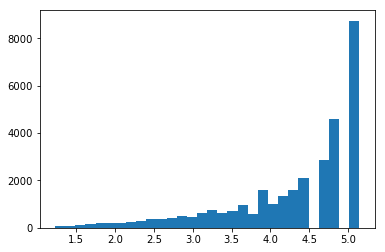

In [83]:
plt.hist(vect.idf_, bins=30);

In [59]:
clf = LogisticRegression(random_state=0, C=0.1)
pca = PCA(1000,random_state=0);
mxtrain = pca.fit_transform(mxtrain.todense())
clf.fit(mxtrain,ytrain);
probtrain = clf.predict_proba(mxtrain)
probtest  = clf.predict_proba(pca.transform(mxtest.todense()))

In [60]:
rocs = [
    {
        'classe':c,
        'roc_train':roc_auc_score(y_true=np.array(ytrain)==c, y_score=probtrain[:,i]),
        'roc_test':roc_auc_score(y_true=np.array(ytest)==c, y_score=probtest[:,i])
    }
    
    for i,c in enumerate(clf.classes_)]

pd.DataFrame(rocs)

,classe,roc_test,roc_train
0,2015,0.601996,0.999641
1,2016,0.574830,1.000000
2,2017,0.709330,0.998818
3,2018,0.887097,1.000000


In [ ]:
plt.plot(pca.explained_variance_.cumsum())

In [66]:
def buildVocab(x):
    voc = set();
    for v in x:
        voc = set(voc.union(set(v)));
    voc = sorted(list(voc));
    voc = {c:i for i,c in enumerate(voc) };
    return voc ;

vocabularyIndex = buildVocab(xtrain)

In [69]:
def ngramToVector(ngram):
    vector = np.zeros(len(vocabularyIndex));
    for c in ngram:
        vector[vocabularyIndex[c]] +=1;
    return vector;

In [71]:
ngramToVector("abc")

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [35]:
from sklearn.preprocessing import LabelBinarizer 

In [36]:
enc = LabelBinarizer ();

In [47]:
enc.fit_transform(np.array([c for c in "casa"]).reshape(-1,1))

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [46]:
enc.classes_

array(['a', 'c', 'd', 'e'], 
      dtype='<U1')

In [41]:
enc.y_type_ 

'multiclass'

In [42]:
enc.sparse_input_ 

False

In [212]:
vect = CountVectorizer(analyzer='word',lowercase=False, min_df=0.05, max_df=0.99, ngram_range=(1,1))
mxtrain = vect.fit_transform(xtrain);
mxtest = vect.transform(xtest);

In [213]:
coo = mxtrain.T * mxtrain

In [214]:
coo.shape

(347, 347)

In [215]:
from sklearn.decomposition import PCA;

pca = PCA(0.90);
coopca = pca.fit_transform(normalize(np.log10(coo.todense()+1),norm='l1'));


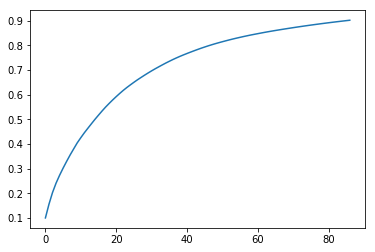

In [216]:
plt.plot(pca.explained_variance_ratio_.cumsum());

In [217]:
vect.vocabulary_

{'10': 0,
 '2014': 1,
 '2015': 2,
 '2016': 3,
 '2017': 4,
 'AG': 5,
 'All': 6,
 'As': 7,
 'Association': 8,
 'Attribution': 9,
 'Author': 10,
 'Authorship': 11,
 'Based': 12,
 'CLEF': 13,
 'Copyright': 14,
 'Elsevier': 15,
 'English': 16,
 'For': 17,
 'However': 18,
 'IEEE': 19,
 'Identification': 20,
 'In': 21,
 'International': 22,
 'It': 23,
 'One': 24,
 'Our': 25,
 'PAN': 26,
 'Publishing': 27,
 'Spanish': 28,
 'Springer': 29,
 'Switzerland': 30,
 'The': 31,
 'These': 32,
 'This': 33,
 'To': 34,
 'University': 35,
 'Using': 36,
 'We': 37,
 'able': 38,
 'about': 39,
 'accuracy': 40,
 'achieved': 41,
 'against': 42,
 'aims': 43,
 'algorithm': 44,
 'algorithms': 45,
 'all': 46,
 'allows': 47,
 'also': 48,
 'among': 49,
 'an': 50,
 'analysis': 51,
 'and': 52,
 'any': 53,
 'application': 54,
 'applications': 55,
 'applied': 56,
 'approach': 57,
 'approaches': 58,
 'are': 59,
 'art': 60,
 'article': 61,
 'articles': 62,
 'as': 63,
 'associated': 64,
 'at': 65,
 'attributes': 66,
 'attrib

In [218]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [219]:
indexes = {vect.vocabulary_[k]:k  for k in vect.vocabulary_}

In [220]:
cosine = cosine_similarity(coopca,coopca)

In [221]:
icosine = np.argsort(cosine[vect.vocabulary_['algorithms']])

In [222]:
[indexes[v] for v in icosine[0:10]]

['without',
 'determine',
 'suggest',
 'significantly',
 'whether',
 'decision',
 'specific',
 'distance',
 'describes',
 'Spanish']

In [201]:
plt.matshow(normalize(coo[0:10,0:10],norm='l1')*100)

C:\Users\custjo01\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


ValueError: not enough values to unpack (expected 2, got 0)

In [226]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [308]:
class MySentences(object):
    def __init__(self, text):
        self.text = text
 
    def __iter__(self):
        for t in self.text:
            t = re.sub(r'[.\\,\']',' ',t)
            t = re.sub(r'\b([\w\d]+)(ies|es|s|ing)\b',r' \1 ',t)
            t = re.sub(r'\s{2,}',' ',t)
            yield t.lower().split();

In [309]:
model = Word2Vec(MySentences(abstracts), size=1000, window=10, min_count=2, workers=4, iter=100)

In [314]:
model.wv.most_similar('authorship', topn=30)

[('closed-set', 0.6903082728385925),
 ('open-set', 0.5136997699737549),
 ('problem', 0.5000991821289062),
 ('binary', 0.42407655715942383),
 ('cros', 0.4093531370162964),
 ('stylometry', 0.4090375006198883),
 ('today', 0.3820345401763916),
 ('forensic', 0.37841951847076416),
 ('style-based', 0.37615418434143066),
 ('-topic', 0.3757123351097107),
 ('author', 0.3696101903915405),
 ('define', 0.3610795736312866),
 ('employed', 0.35469022393226624),
 ('-genre', 0.35425931215286255),
 ('mail', 0.34912487864494324),
 ('referred', 0.3478485643863678),
 ('task', 0.34447863698005676),
 ('branch', 0.344343900680542),
 ('investigated', 0.34233710169792175),
 ('approache', 0.33969277143478394),
 ('application', 0.3328985273838043),
 ('setting', 0.33069393038749695),
 ('main', 0.32628631591796875),
 ('overcome', 0.3257198929786682),
 ('novel', 0.31752291321754456),
 ('extensive', 0.31216830015182495),
 ('realistic', 0.3112994134426117),
 ('deal', 0.30726420879364014),
 ('difficult', 0.3065592050552

In [311]:
from gensim.models.fasttext import FastText

In [312]:
modelf = FastText(MySentences(abstracts), size=1000, window=10, min_count=2, workers=4, iter=100)

In [316]:
[v for v in modelf.wv.most_similar('authorship',topn=30) if v[1]>0.5]

[('subauthorship', 0.9486616253852844),
 ('authorial', 0.8317183256149292),
 ('authorweb', 0.8120629191398621),
 ('author’s', 0.8027327656745911),
 ('author', 0.7773070335388184),
 ('authored', 0.7582493424415588),
 ('authoritative', 0.7210692167282104),
 ("author's", 0.7010636329650879),
 ('authority', 0.6868267059326172),
 ('owner/author', 0.6690149903297424),
 ('subauthor', 0.6657428741455078),
 ('multi-author', 0.6238501071929932),
 ('multi-authored', 0.597987174987793),
 ('authorship-identification', 0.5628656148910522)]

In [329]:
def heap(a, min=0):
    change = True;
    l= len(a)-1;
    while change:
        change = False;
        for i in range(l-min):
            if i == l:
                break;
            j = l -i + min;
            jj = int(j/2);
            if a[jj] > a[j]:
                temp = a[jj];
                a[jj] = a[j];
                a[j] = temp;
                change = True;
    return a;
def heapp(a):
    l = len(a) - 1;
    

a = [9,8,7,6,5,4,3,2,1];
heap(a,1)            

IndexError: list index out of range